In [1]:
# path to Mendel docs: /Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/data

In [2]:
# path to Mendel manifest: /Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/manifest

In [1]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
data_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/data/mendel_output")
manifest_dir = Path("/Volumes/GH-ent-data-platform-rwe/share/Data/Mendel/nlp-poc-073123/manifest/mendel_output")

In [3]:
our_results_dir = Path("/Users/cpan/Desktop/Entities_compare")

In [4]:
pwd

'/Users/cpan/Desktop'

In [6]:
def load_data_output(data_dir, folder_name):
    data_lst = []
    folder = data_dir / folder_name
    if folder.exists() and folder.is_dir(): 
        json_files = list(folder.glob('*.json')) 
        
        for json_file in json_files: 
            with open(json_file, 'r') as file: 
                for line in file:
                    json_data = json.loads(line)  # Load each line as a separate JSON object
                    data_lst.append(json_data)
    else:
        print("The folder does not exist")
    return data_lst

def load_json_our_results(file_name):
    file_path = our_results_dir / file_name
    with open(file_path, 'r') as file:
        json_data = json.load(file)
        
    json_data_df = pd.DataFrame(json_data)
    return json_data_df

In [7]:
lung_data = load_data_output(data_dir, 'lung')

In [8]:
lung_data_manifest = load_data_output(manifest_dir, 'lung')

In [9]:
print(len(lung_data))
print(len(lung_data_manifest))

2951
148


In [10]:
lung_data[0]

{'patient_id': 'pt-01h5b98ye32jt51yvphb320c4v',
 'event_id': 'evt-01h6pdzq3rmqhzp9ywwvn01w7n',
 'event_type': 'ECOG Status',
 'endpoint_name': 'ECOG Status',
 'property_type': 'Concept',
 'property_value_type': 'Concept',
 'concept_values': [{'concept_name': 'ECOG 1', 'mendel_cid': '233850'}],
 'property_evidences': [{'document_id': 'doc-01h5ec8evvc82s4sjfdf7ztps3',
   'mention': '1 ',
   'start_char': 6611,
   'end_char': 6613}]}

In [11]:
lung_data_manifest[0]

{'mendel_patient_id': 'pt-01h5b98ye32jt51yvphb320c4v',
 'customer_patient_id': 'A0598896',
 'resolve_path': 's3://mendel-guardant-data/outbound/073123/data/mendel_output/lung/pt-01h5b98ye32jt51yvphb320c4v.json',
 'tenant_num': 1,
 'tenant_domain': 'https://gdt1-api-sandbox.mendel.ai/v1/',
 'site_name': 'guardant'}

In [12]:
def create_matched_dataframe(data, manifest):
    # Create DataFrames from the lists
    data_df = pd.DataFrame(data)
    manifest_df = pd.DataFrame(manifest)
    
    # Merge the DataFrames based on 'patient_id' and 'mendel_patient_id'
    merged_df = pd.merge(data_df, manifest_df,
                         left_on='patient_id', right_on='mendel_patient_id')
    
    # Extract 'mention' from 'property_evidences' list of dictionaries
    merged_df['mention'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['mention'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Extract all concept names from 'concept_values' lists
    merged_df['all_concept_names'] = merged_df['concept_values'].apply(
        lambda x: ', '.join([c['concept_name'] for c in x]) if isinstance(x, list) else None)
    
    # Extract 'document_id', 'start_char', and 'end_char' for the corresponding 'mention'
    merged_df['document_id'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['document_id'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['start_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['start_char'] if isinstance(x, list) and len(x) > 0 else None)
    merged_df['end_char'] = merged_df['property_evidences'].apply(
        lambda x: x[0]['end_char'] if isinstance(x, list) and len(x) > 0 else None)
    
    # Select the desired columns
    selected_columns = ['customer_patient_id', 'event_type', 'confidence_score', 
                        'property_type', 'property_value_type', 'mention', 'all_concept_names',
                        'document_id', 'start_char', 'end_char']
    
    # Create the final DataFrame with selected columns
    final_df = merged_df[selected_columns].copy()
    
    return final_df

In [13]:
lung_mendel_df = create_matched_dataframe(lung_data, lung_data_manifest)

In [14]:
lung_mendel_df.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char
0,A0598896,ECOG Status,NaN,Concept,Concept,1,ECOG 1,doc-01h5ec8evvc82s4sjfdf7ztps3,6611.0,6613.0
1,A0598896,Neoplasm,0.927352,Concept,Concept,adenocarcinoma of lung,Malignant Lung Neoplasm,doc-01h5ec8evwptzq7sq9sp85j8yc,1452.0,1474.0
2,A0598896,Biomarker,NaN,Biomarker Tested,Concept,RET,RET,doc-01h5ec8evy1g86z050tbhy4q81,8395.0,8398.0
3,A0598896,Biomarker,NaN,Method of Testing,Concept,sequenced using the illumina platform,Next Generation Sequencing,doc-01h5ec8evy1g86z050tbhy4q81,6121.0,6158.0
4,A0598896,Biomarker,NaN,Categorical Value,Concept,NOT DETECTED,Negative,doc-01h5ec8evy1g86z050tbhy4q81,1332.0,1344.0


In [15]:
# load our results 
lung_our_df = load_json_our_results('lung_cancer_293_docs_entities.json')

In [16]:
lung_our_df.head()

,file_name,dates,important dates,diseases,smoking,smoking_keyword,ecogs,test_results
0,A0645947_MedRec1.txt,"[{'start': 190, 'end': 200, 'text': '08/30/202...","[{'keyword': 'collected:', 'start': 179, 'end'...","[{'start': 635, 'end': 648, 'text': 'breast ca...",no,,"[{'start': 3626, 'end': 3637, 'text': 'perform...",[]
1,A0592320_MedRec1.txt,"[{'start': 11, 'end': 21, 'text': '12/22/2022'...",[{'keyword': 'received a left-sided thoracente...,"[{'start': 194, 'end': 211, 'text': 'birth: 05...",yes,smoking,[],[]
2,A0598093_MedRec1.txt,"[{'start': 297, 'end': 307, 'text': '10/19/202...",[],"[{'start': 651, 'end': 655, 'text': 'copd', 'l...",yes,smoker,[],[]
3,A0596116_MedRec1.txt,"[{'start': 238, 'end': 248, 'text': '10/18/202...",[],"[{'start': 84, 'end': 98, 'text': 'florida can...",yes,smoking,"[{'start': 3623, 'end': 3634, 'text': 'perform...",[]
4,A0598080_MedRec1.txt,"[{'start': 0, 'end': 10, 'text': '11/28/2822',...",[{'keyword': 'received in four parts labeled w...,"[{'start': 426, 'end': 434, 'text': 'thompson'...",yes,smoking,"[{'start': 2800, 'end': 2818, 'text': 'perform...",[]


In [45]:
# lung_our_df['diseases'][:2][0]

### Data Analysis 

In [17]:
# Display basic information about the DataFrame
print(lung_mendel_df.info())
# Summary statistics for numeric columns
print(lung_mendel_df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2951 entries, 0 to 2950
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_patient_id  2951 non-null   object 
 1   event_type           2951 non-null   object 
 2   confidence_score     473 non-null    float64
 3   property_type        2951 non-null   object 
 4   property_value_type  2943 non-null   object 
 5   mention              2943 non-null   object 
 6   all_concept_names    2239 non-null   object 
 7   document_id          2943 non-null   object 
 8   start_char           2943 non-null   float64
 9   end_char             2943 non-null   float64
dtypes: float64(3), object(7)
memory usage: 253.6+ KB
None
       confidence_score     start_char       end_char
count        473.000000    2943.000000    2943.000000
mean           0.656474    7349.178050    7362.111791
std            0.205090   14560.846687   14561.298739
min            0.3

In [25]:
def create_colorful_bar_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=x_col, y=y_col, data=data, palette="viridis")
    plt.title(title)
    plt.xticks(rotation=45)
    
    # Display actual counts on the bars
    for index, value in enumerate(y_col):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=10, color='black')
    
    plt.show()

# Function to create a colorful box plot
def create_colorful_box_plot(data, x_col, y_col, title):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_col, y=y_col, data=data, palette="plasma")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_top_concept_counts(data_df, column_name, top_n=20):
    concept_counts = data_df[column_name].value_counts()[:top_n]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=concept_counts.index, y=concept_counts.values, palette="viridis")
    plt.xticks(rotation=90)
    plt.xlabel(column_name)
    plt.ylabel("Count")
    plt.title(f"Lung Cancer Top {top_n} {column_name} Counts")
    for i, count in enumerate(concept_counts.values):
        plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

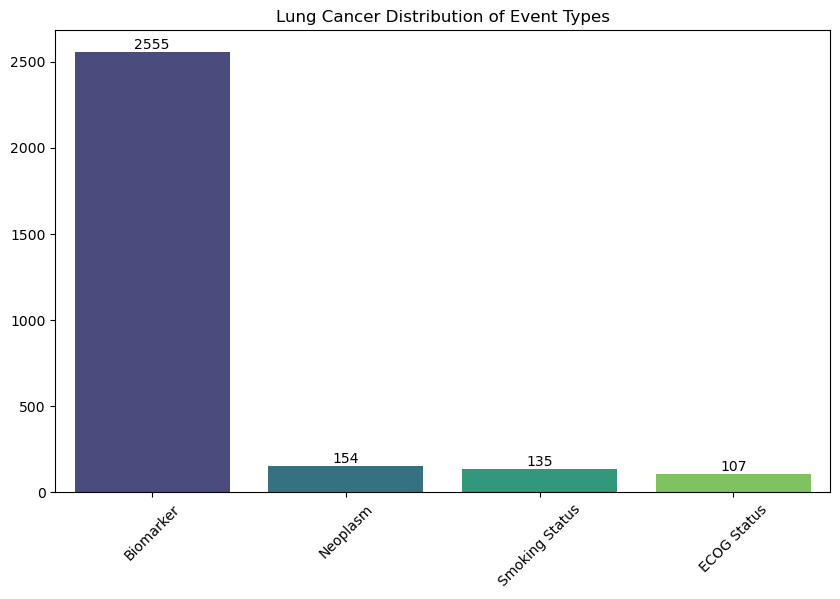

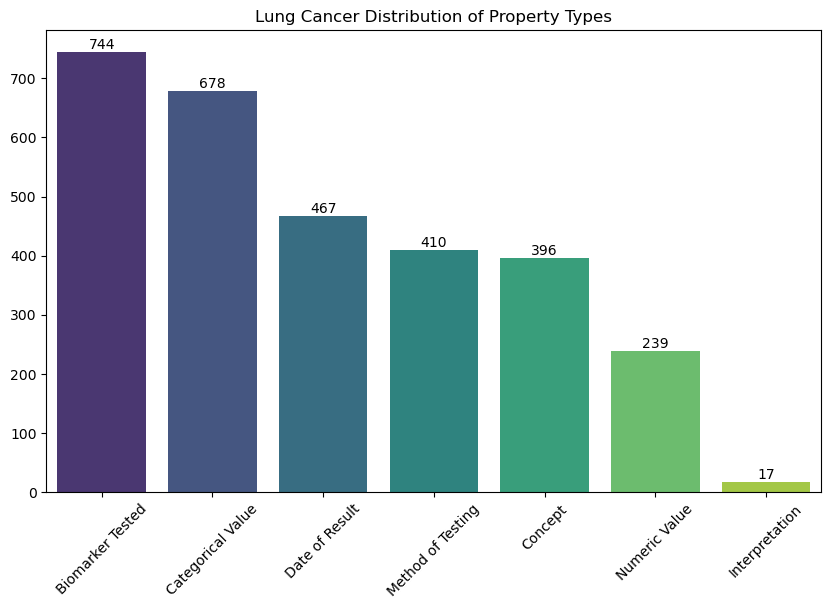

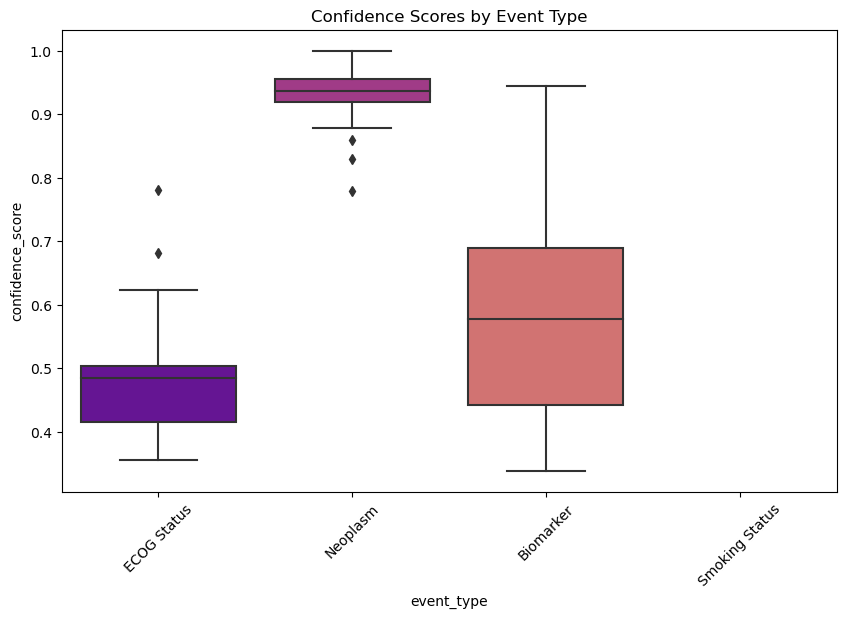

In [22]:
# Distribution of event types
event_type_counts = lung_mendel_df['event_type'].value_counts()
create_colorful_bar_plot(lung_mendel_df, event_type_counts.index, event_type_counts.values, 'Lung Cancer Distribution of Event Types')

# Distribution of property types
property_type_counts = lung_mendel_df['property_type'].value_counts()
create_colorful_bar_plot(lung_mendel_df, property_type_counts.index, property_type_counts.values, 'Lung Cancer Distribution of Property Types')

# Box plot of confidence scores by event type
create_colorful_box_plot(lung_mendel_df, 'event_type', 'confidence_score', 'Confidence Scores by Event Type')

In [23]:
print(len(lung_mendel_df['all_concept_names'].unique()))
lung_concept_counts = lung_mendel_df['all_concept_names'].value_counts()
lung_concept_counts[:20]

94


Next Generation Sequencing         277
Gene Mutation Negative             230
Gene Mutation                      157
Malignant Lung Neoplasm            147
EGFR                               124
Negative                           117
PDL1                               109
ALK                                 96
TP53                                69
Immunohistochemistry                68
Former Smoker                       68
ERBB2                               65
MET                                 65
RET                                 64
Positive                            59
ECOG 1                              49
Current Smoker                      37
ECOG 0                              32
Never Smoker                        27
Variant Of Unknown Significance     25
Name: all_concept_names, dtype: int64

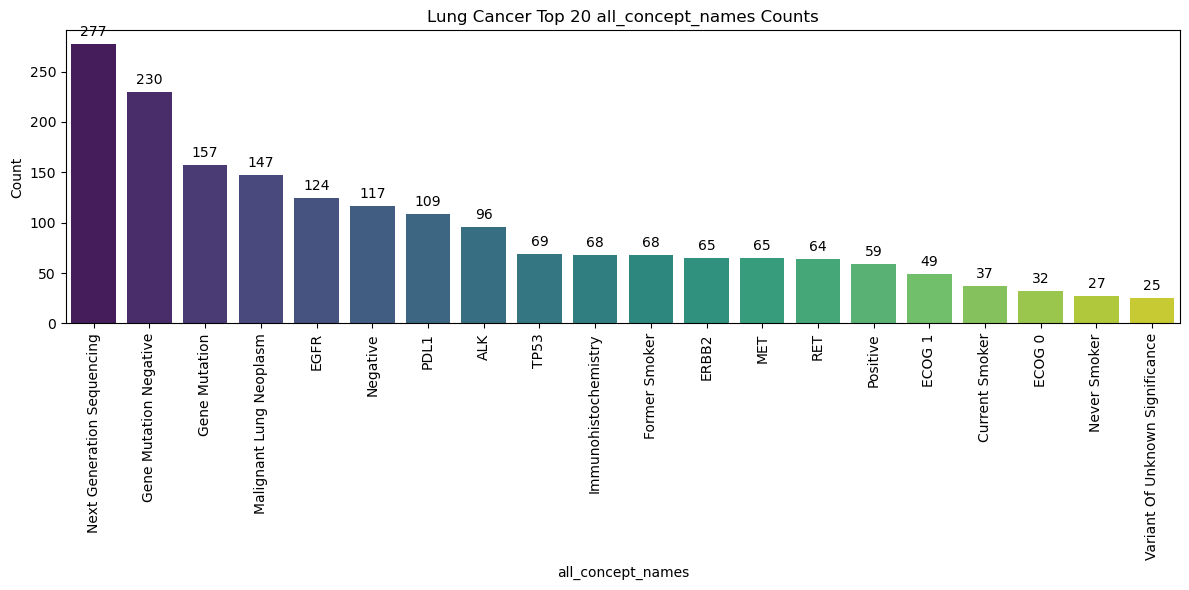

In [26]:
plot_top_concept_counts(lung_mendel_df, 'all_concept_names', top_n=20)

### Results Extraction Comparison

In [29]:
# get dataframe with the same patients to compare extracted results 
import re

def merge_common_df(our_df, filtered_df):
    # Extract patient IDs from file names in our_df
    our_df['patient_id'] = our_df['file_name'].apply(lambda x: re.search(r'[A-Za-z0-9]+', x).group())

    # Filter unique patient IDs from our_df
    unique_patient_ids = our_df['patient_id'].unique()
    unique_our_df = our_df[our_df['patient_id'].isin(unique_patient_ids)]

    # Merge with filtered_df based on customer_patient_id
    merged_df = pd.merge(filtered_df, unique_our_df, left_on='customer_patient_id', right_on='patient_id')
    
    # Drop duplicates based on customer_patient_id
    merged_df = merged_df.drop_duplicates(subset='customer_patient_id', keep = 'first')

    return merged_df

In [98]:
merged_lung_df = merge_common_df(lung_our_df, lung_mendel_df)
print(merged_lung_df.shape[0])

146


#### Smoking Status

In [30]:
lung_smoking_mendel = lung_mendel_df[lung_mendel_df['event_type'] == 'Smoking Status']
merged_lung_df_smoking = merge_common_df(lung_our_df, lung_smoking_mendel)

In [31]:
print(merged_lung_df_smoking.shape)

(133, 19)


In [32]:
def plot_merged_counts(data, column_name, title):
    plt.figure(figsize=(10, 6))
    unique_values = data[column_name].unique()
    num_unique_values = len(unique_values)
    color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors
    
    ax = data[column_name].value_counts().plot(kind='bar', color=[color_map(i) for i in range(num_unique_values)])
    
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
    
    plt.title(title)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_38288/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


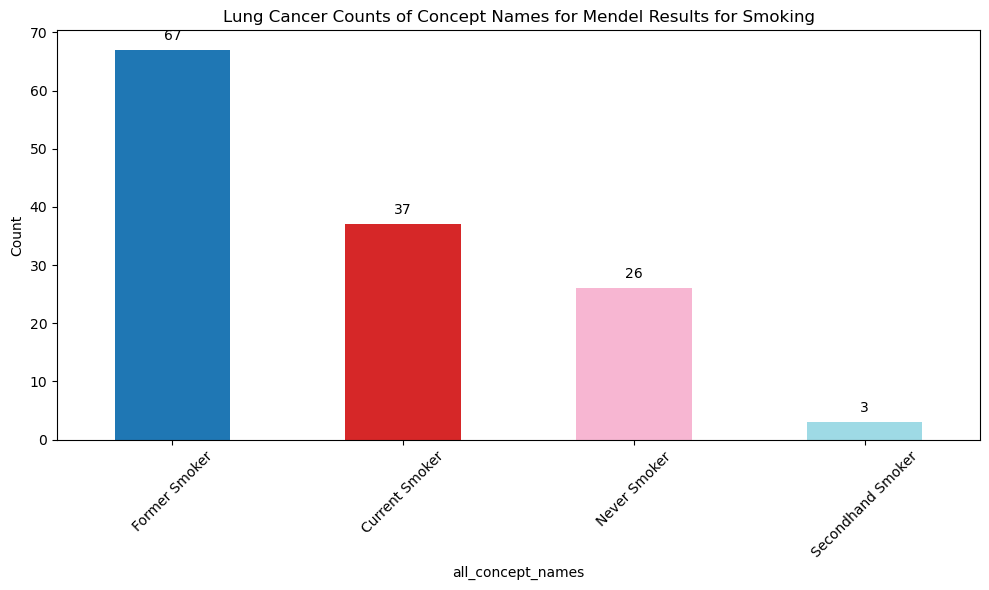

/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_38288/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


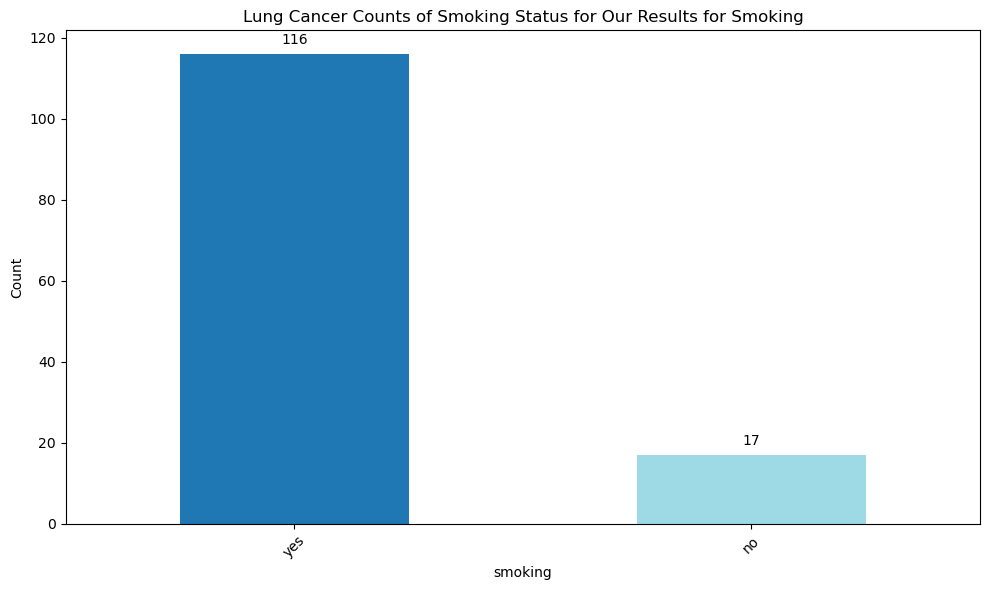

In [33]:
# Plotting counts of 'all_concept_names' for Mendel 
plot_merged_counts(merged_lung_df_smoking, 'all_concept_names', 'Lung Cancer Counts of Concept Names for Mendel Results for Smoking')

# Plotting counts of 'smoking' for our results 
plot_merged_counts(merged_lung_df_smoking, 'smoking', 'Lung Cancer Counts of Smoking Status for Our Results for Smoking')

#### Ecogs

In [34]:
lung_mendel_df.columns

Index(['customer_patient_id', 'event_type', 'confidence_score',
       'property_type', 'property_value_type', 'mention', 'all_concept_names',
       'document_id', 'start_char', 'end_char'],
      dtype='object')

In [35]:
lung_mendel_ecogs = lung_mendel_df[lung_mendel_df['event_type'] == 'ECOG Status']

In [36]:
# get the dataframe with same pateints
merged_lung_df_ecogs = merge_common_df(lung_our_df, lung_mendel_ecogs)

In [37]:
print(merged_lung_df_ecogs.shape)

(105, 19)


In [38]:
mendel_ecogs_counts = merged_lung_df_ecogs['all_concept_names'].count()
print("Number of Mendel ecogs counts: ", mendel_ecogs_counts)

Number of Mendel ecogs counts:  105


In [39]:
non_empty_ecogs_count = merged_lung_df_ecogs['ecogs'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0).sum()
print("Number of our non-empty ecogs:", non_empty_ecogs_count)

Number of our non-empty ecogs: 84


/var/folders/j5/jwflgqw937z81d1hsr90cfn80000gq/T/ipykernel_38288/3455718742.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', num_unique_values)  # Get a colormap with enough colors


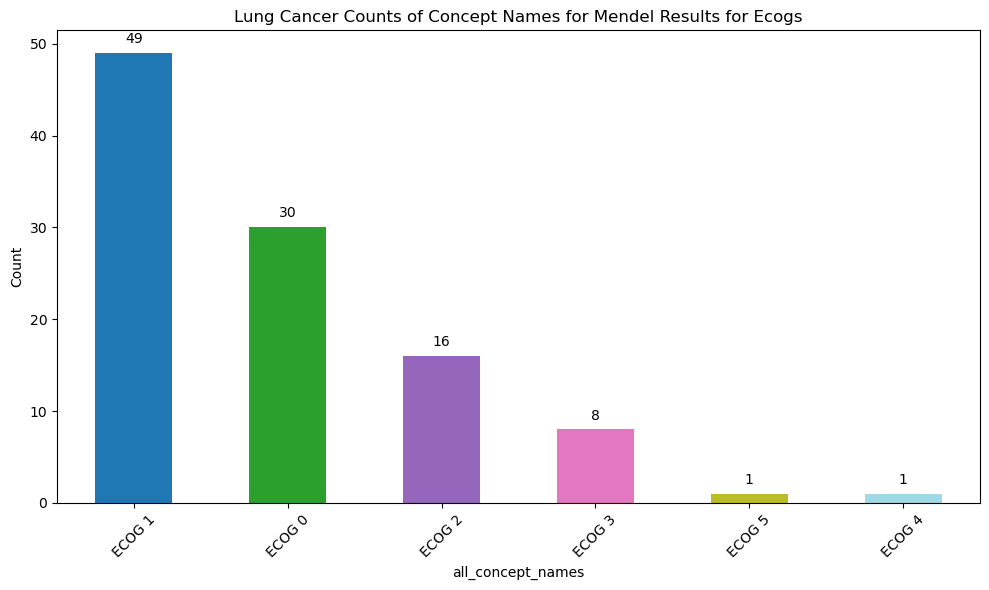

In [99]:
plot_merged_counts(merged_lung_df_ecogs, 'all_concept_names', 'Lung Cancer Counts of Concept Names for Mendel Results for Ecogs')

#### Important Dates

In [46]:
# Date of Result
lung_date_mendel = lung_mendel_df[lung_mendel_df['property_type']=='Date of Result']

In [47]:
lung_date_mendel[:3]

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char
5,A0598896,Biomarker,NaN,Date of Result,String,001-30-2022,None,doc-01h5ec8evy1g86z050tbhy4q81,326.0,337.0
6,A0598896,Biomarker,NaN,Date of Result,String,001-30-2022,None,doc-01h5ec8evy1g86z050tbhy4q81,326.0,337.0
10,A0598896,Biomarker,NaN,Date of Result,String,001-30-2022,None,doc-01h5ec8evy1g86z050tbhy4q81,326.0,337.0


In [49]:
merged_lung_df_dates = merge_common_df(lung_our_df, lung_date_mendel)

In [50]:
merged_lung_df_dates.columns

Index(['customer_patient_id', 'event_type', 'confidence_score',
       'property_type', 'property_value_type', 'mention', 'all_concept_names',
       'document_id', 'start_char', 'end_char', 'file_name', 'dates',
       'important dates', 'diseases', 'smoking', 'smoking_keyword', 'ecogs',
       'test_results', 'patient_id'],
      dtype='object')

In [97]:
merged_lung_df_dates.shape

(74, 19)

In [55]:
print("Number of results dates extracted by Mendel: ", len(merged_lung_df_dates['mention']))

Number of results dates extracted by Mendel:  74


In [52]:
non_empty_important_dates_count = merged_lung_df_dates['important dates'].apply(lambda x: 1 if isinstance(x, list) and len(x) > 0 else 0).sum()
print("Number of our non-empty important dates:", non_empty_important_dates_count)

Number of our non-empty important dates: 65


#### biomarker & diseases

In [67]:
lung_biomarker = lung_mendel_df[lung_mendel_df['event_type']=='Biomarker']

In [68]:
merged_lung_biomarker = merge_common_df(lung_our_df, lung_biomarker)

In [69]:
merged_lung_biomarker.head()

,customer_patient_id,event_type,confidence_score,property_type,property_value_type,mention,all_concept_names,document_id,start_char,end_char,file_name,dates,important dates,diseases,smoking,smoking_keyword,ecogs,test_results,patient_id
0,A0598896,Biomarker,NaN,Biomarker Tested,Concept,RET,RET,doc-01h5ec8evy1g86z050tbhy4q81,8395.0,8398.0,A0598896_MedRec1.txt,"[{'start': 3732, 'end': 3742, 'text': '10/14/2...",[],"[{'start': 255, 'end': 268, 'text': 'birth: ju...",yes,smoking,"[{'start': 6682, 'end': 6700, 'text': 'perform...",[],A0598896
48,A0597519,Biomarker,NaN,Biomarker Tested,Concept,EGFR,EGFR,doc-01h5ecttyg045jyr6sga0j5amq,7040.0,7044.0,A0597519_MedRec1.txt,"[{'start': 2383, 'end': 2393, 'text': '10/11/4...",[],"[{'start': 225, 'end': 230, 'text': 'nsclc', '...",yes,smoker,[],[],A0597519
50,A0598994,Biomarker,NaN,Categorical Value,Concept,VARIANTS OF UNKNOWN SIGNIFICANCE,Variant Of Unknown Significance,doc-01h5ectt3gekx8hcf03fwhmm49,6311.0,6343.0,A0598994_MedRec1.txt,"[{'start': 20, 'end': 30, 'text': '12/27/2022'...",[{'keyword': 'received 10 mg iv dexamethasone ...,"[{'start': 312, 'end': 321, 'text': 'allergies...",no,,[],[],A0598994
68,A0547649,Biomarker,NaN,Categorical Value,Concept,negative,Negative,doc-01h5ebz9wtjt329va4ccksa3c6,1621.0,1629.0,A0547649_MedRec1.txt,"[{'start': 17819, 'end': 17829, 'text': '09/02...","[{'keyword': 'collected:', 'start': 20263, 'en...","[{'start': 278, 'end': 294, 'text': 'birth: 7/...",yes,smoker,[],[],A0547649
74,A0546705,Biomarker,NaN,Biomarker Tested,Concept,EGFR,EGFR,doc-01h5ecttpr7678fmdyfbchq18k,5986.0,5991.0,A0546705_MedRec1.txt,"[{'start': 3887, 'end': 3897, 'text': '06/05/1...",[{'keyword': 'collected date/time 7/14/2022 15...,"[{'start': 352, 'end': 367, 'text': 'birth: 6/...",yes,smoking,[],[],A0546705


In [71]:
print("Number of unique biomarkers extracted by Mendel: ", len(merged_lung_biomarker['mention'].unique()))

Number of unique biomarkers extracted by Mendel:  67


In [72]:
unique_diseases = set()
for item_lst in merged_lung_biomarker['diseases']:
    for item in item_lst: 
        if item['text'] not in unique_diseases: 
            unique_diseases.add(item['text'])
print("Number of unique diseases extracted by us: ", len(list(unique_diseases)))

Number of unique diseases extracted by us:  5940


In [73]:
# get diseases counts extracted by us 
def get_top_count_disease(df):
    disease_count = {}
    for item_lst in df['diseases']:
        for item in item_lst:
            disease_text = item['text']
            if disease_text in disease_count:
                disease_count[disease_text] += 1
            else:
                disease_count[disease_text] = 1

    # Sort the dictionary by frequency in descending order
    sorted_disease_count = dict(sorted(disease_count.items(), key=lambda item: item[1], reverse=True))
    return sorted_disease_count

In [87]:
def plot_top_n_attributes(top_n, sorted_disease_count, title, x_name):

    # Select the top N disease types
    top_diseases = list(sorted_disease_count.keys())[:top_n]
    top_disease_counts = [sorted_disease_count[disease] for disease in top_diseases]

    # Visualize the top N diseases
    plt.figure(figsize=(10, 6))
    plt.barh(top_diseases, top_disease_counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Count')
    plt.ylabel(x_name)
    plt.gca().invert_yaxis()  # Invert y-axis to display highest count at the top
    plt.tight_layout()
    plt.show()

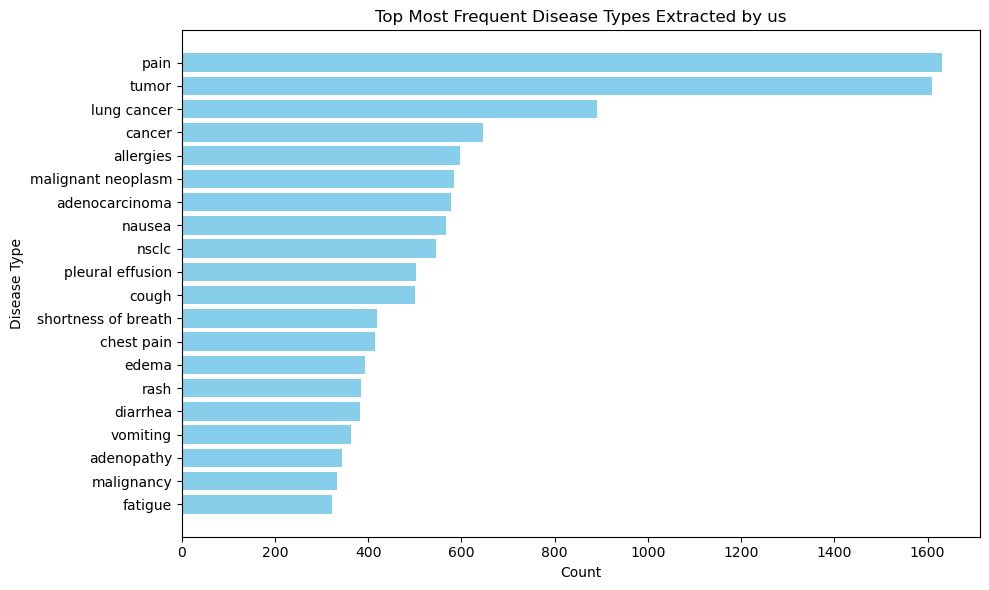

In [88]:
# visualize the top 20 diseases extracted by us 
our_top_diseases = get_top_count_disease(merged_lung_biomarker)
# plot top 20 diseases 
plot_top_n_attributes(20, our_top_diseases, 'Top Most Frequent Disease Types Extracted by us', 'Disease Type')

In [89]:
# get top biomarker counts extracted by Mendel 
# get diseases counts extracted by us 
from collections import Counter
def get_top_count_biomarker_attributes(df, col_name):
    attributes = df[col_name].values
    att_cnt_dict = Counter(attributes)
    sorted_att_cnt_dict = dict(sorted(att_cnt_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_att_cnt_dict

In [90]:
# all_concept_names
sorted_biomarker_concept_names_dict = get_top_count_biomarker_attributes(merged_lung_biomarker, 'all_concept_names')

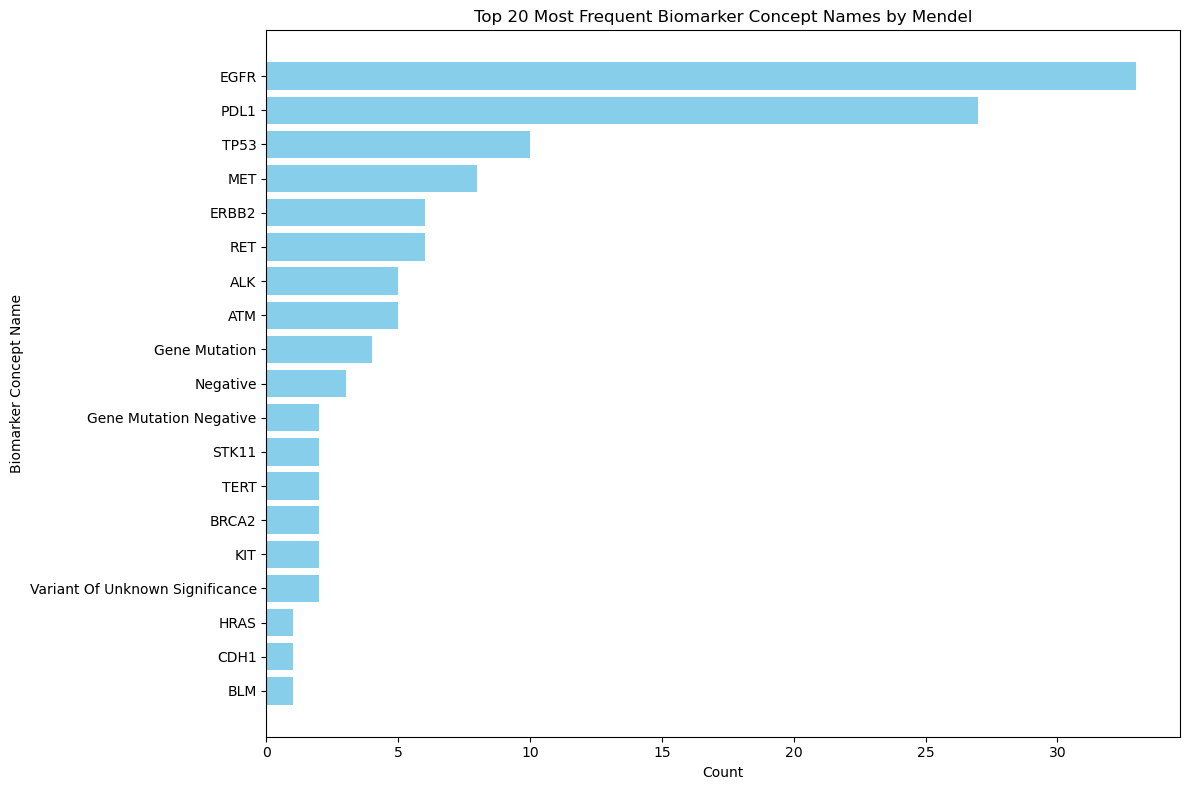

In [96]:
# top 20 biomarker concept names by Mendel 
import matplotlib.pyplot as plt

# Define the function to get top count attributes
def get_top_count_attributes(attributes_dict, top_n=10):
    sorted_attributes_dict = dict(sorted(attributes_dict.items(), key=lambda item: item[1], reverse=True))
    top_attributes = list(sorted_attributes_dict.keys())[:top_n]
    top_counts = [sorted_attributes_dict[attr] for attr in top_attributes]
    return top_attributes, top_counts

# Get top biomarker concept names and their counts
top_biomarker_names, top_biomarker_counts = get_top_count_attributes(sorted_biomarker_concept_names_dict, top_n=20)

# Filter out None values
top_biomarker_names = [name for name in top_biomarker_names if name is not None]
top_biomarker_counts = [count for name, count in zip(top_biomarker_names, top_biomarker_counts) if name is not None]

# Visualize the top biomarker concept names
plt.figure(figsize=(12, 8))
plt.barh(top_biomarker_names, top_biomarker_counts, color='skyblue')
plt.title('Top 20 Most Frequent Biomarker Concept Names by Mendel')
plt.xlabel('Count')
plt.ylabel('Biomarker Concept Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()